# <font color='orange'>Numerical Exercise 12</font>

In this last exercise, the goal is to exploit the power of Neural Networks (deep and convolutional), to address a typical **classification problem**: the recognition of images in which *hand-written digits* (0-9) appear. <br>
First you need to create the datasets with which to carry out the training of the various networks that I will build, formatting the data in a manner appropriate to be used as input and output of an NN. This task is made easy by Python modules of tensorflow and keras.

In [1]:
from IPython.display import HTML, Image

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<a href="javascript:code_toggle()"> Show/Hide code cells </a>.''')

In [2]:
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [3]:
#Standard Modules
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

#NN Modules
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Input  #Basic FFNN 
from tensorflow.keras.layers import Dropout, BatchNormalization  #Regularization
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten  #Convolutional
from tensorflow.keras.callbacks import History

from PIL import Image
import sys
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

Load MNIST Dataset
Manipulation
Datasets created successfully
A hand-written digits of the MNIST Dataset with categorical label [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


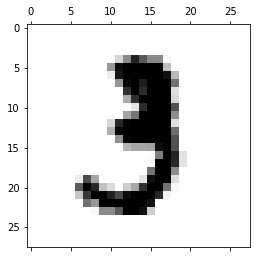

In [4]:
############################
#Creation of the Datasets
#Deep FeedForward Neural Network
#MNIST Hand-written Digits
############################

'''

    (For more details see Exercise Sheet)
    Input Data --> (60000, 28, 28) --> (60000, 784)
    Output Data --> (60000) --> (60000, 10)

'''

###
#load the MNIST Datasets
###
print('Load MNIST Dataset')
img_rows, img_cols = 28, 28  #Number of pixels
N_category = 10  #10 digits (0-9)
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

###
#Appropriate manipulation
###
print('Manipulation')
x_train = x_train.reshape(x_train.shape[0], img_rows*img_cols)
x_test = x_test.reshape(x_test.shape[0], img_rows*img_cols)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255  #rescaling in [0, 1]
x_test /= 255
y_train = tf.keras.utils.to_categorical(y_train, N_category)
y_test = keras.utils.to_categorical(y_test, N_category)

print('Datasets created successfully')
print('A hand-written digits of the MNIST Dataset with categorical label', y_train[10])
plt.matshow(x_train[10, :].reshape(28,28), cmap='binary')
plt.show()

## <font color='blue'>Exercise 12.1</font>

Once I create the datasets appropriately, I build a Deep Neural Network (DNN) that is able to recognize an image related to a hand-written digit. The goal of the exercise is to study how the performance of this DNN changes depending on the optimizer that is used.


I decide to keep the same architecture proposed in the text of the delivery, possibly making a few minor changes that I will explicitly report later.<br>
As for the choice of the optimizer instead, I decide to compare the following methods:

- **SGD**: standard choice
- **Adagrad** <br>One of the disadvantages of some optimizers is that the learning rate is constant for all parameters and for each cycle. This optimizer changes the learning rate. It changes the learning rate for each parameter and at every time step. It’s a type second order optimization algorithm. It makes big updates for less frequent parameters and a small step for frequent parameters. The advantages of using this optimizer are that learning rate changes for each training parameter, it does not need to manually tune the learning rate, is able to train on sparse data. In contrast it is computationally expensive as a need to calculate the second order derivative and the learning rate is always decreasing results in slow training.
- **AdaDelta** <br>It is an extension of Adagrad which tends to remove the decaying learning rate problem of it. Instead of accumulating all previously squared gradients, Adadelta limits the window of accumulated past gradients to some fixed size. In this exponentially moving average is used rather than the sum of all the gradients. Now the learning rate does not decay and the training does not stop, but computationally expensiveness continues to remain.
- **Adam** <br>The Adaptive Moment Estimation works with momentums of first and second order. The intuition behind the Adam is that we don’t want to roll so fast just because we can jump over the minimum, we want to decrease the velocity a little bit for a careful search. This method is too fast and converges rapidly and rectifies vanishing learning rate, high variance; it still remains computationally costly.


I train the DNN for $ 20 $ epochs, changing the optimizer and comparing the results between them.

In [5]:
############################
#Creation of a 
#Deep Neural Network
############################
def create_DNN(**Params):
    #Set default parameters
    Params.setdefault('NN_name', 'DNN')
    Params.setdefault('hidden', 0)
    drop = []
    act = []
    for j in range(Params['hidden']):
        drop.append(0)
    for k in range(Params['hidden']+1):
        act.append('linear')
    Params.setdefault('dropout', drop)
    Params.setdefault('activation', act)
    
    #Create a model instance
    model = tf.keras.Sequential(name=Params['NN_name'])
    model.add(Input(shape=(Params['input_shape'], )))
    
    #Hidden Structure
    if(len(Params['activation']) != (Params['hidden']+1)):
        raise ValueError('Error in the size of activation functions list')
        sys.exit(1)
    if(len(Params['dropout']) != (Params['hidden'])):
        raise ValueError('Error in the size of dropout layers list')
        sys.exit(1)
    if(len(Params['width']) != (Params['hidden'])):
        raise ValueError('Error in the size of layers width list')
        sys.exit(1)
    for depth in range(Params['hidden']):
        model.add(Dense(Params['width'][depth], activation=Params['activation'][depth]))
        if(Params['dropout'][depth]!=0):
            model.add(Dropout(Params['dropout'][depth]))
    
    #Output layer
    model.add(Dense(Params['out_neurons'], activation=Params['activation'][len(Params['activation'])-1]))
    return model

In [6]:
############################
#Compile Method of a 
#Deep Neural Network
############################
def compile_DNN(**Params):
    #Set default parameters
    SGD = tf.keras.optimizers.SGD()
    accuracy = tf.keras.metrics.Accuracy()
    mse = tf.keras.losses.MeanSquaredError()
    Params.setdefault('optimizer', SGD)
    Params.setdefault('loss', mse)
    Params.setdefault('metric', accuracy)
    
    #Compile method
    Params['model'].compile(optimizer=Params['optimizer'], loss=Params["loss"], metrics=[Params['metric']])
    return Params["model"]

In [7]:
############################
#Change the Optimizer
############################
batch_size = 32
N_epoch = 20

SGD = tf.keras.optimizers.SGD()
Adagrad = tf.keras.optimizers.Adagrad()
AdaDelta = tf.keras.optimizers.Adadelta()
Adam = tf.keras.optimizers.Adam()
opt = [SGD, Adagrad, AdaDelta, Adam]
opt_name = ['SGD', 'Adagrad', 'AdaDelta', 'Adam']
dnn_models = []

#Create and Compile the models
for j in range(len(opt)):
    dnn_models.append(create_DNN(
                                 input_shape=img_rows*img_cols, NN_name='DNN_'+str(j+1), hidden=2,
                                 width=[400, 100], out_neurons=N_category, dropout=[0, 0.5],
                                 activation=['relu', 'relu', 'softmax']
                                )
                     )
for m in range(len(dnn_models)):
    compile_DNN(model=dnn_models[m], optimizer=opt[m], 
                loss=tf.keras.losses.categorical_crossentropy, metric='accuracy')

#Training Phase
history = []
for j in range(len(dnn_models)):
    print('Start training phase using '+opt_name[j])
    history.append(
                   dnn_models[j].fit(x_train, y_train,                 
                                     epochs=N_epoch, batch_size=batch_size, 
                                     validation_data=(x_test, y_test), 
                                     shuffle=True, verbose=0)
                  )
    print('End of the training phase\n')

Start training phase using SGD
End of the training phase

Start training phase using Adagrad
End of the training phase

Start training phase using AdaDelta
End of the training phase

Start training phase using Adam
End of the training phase



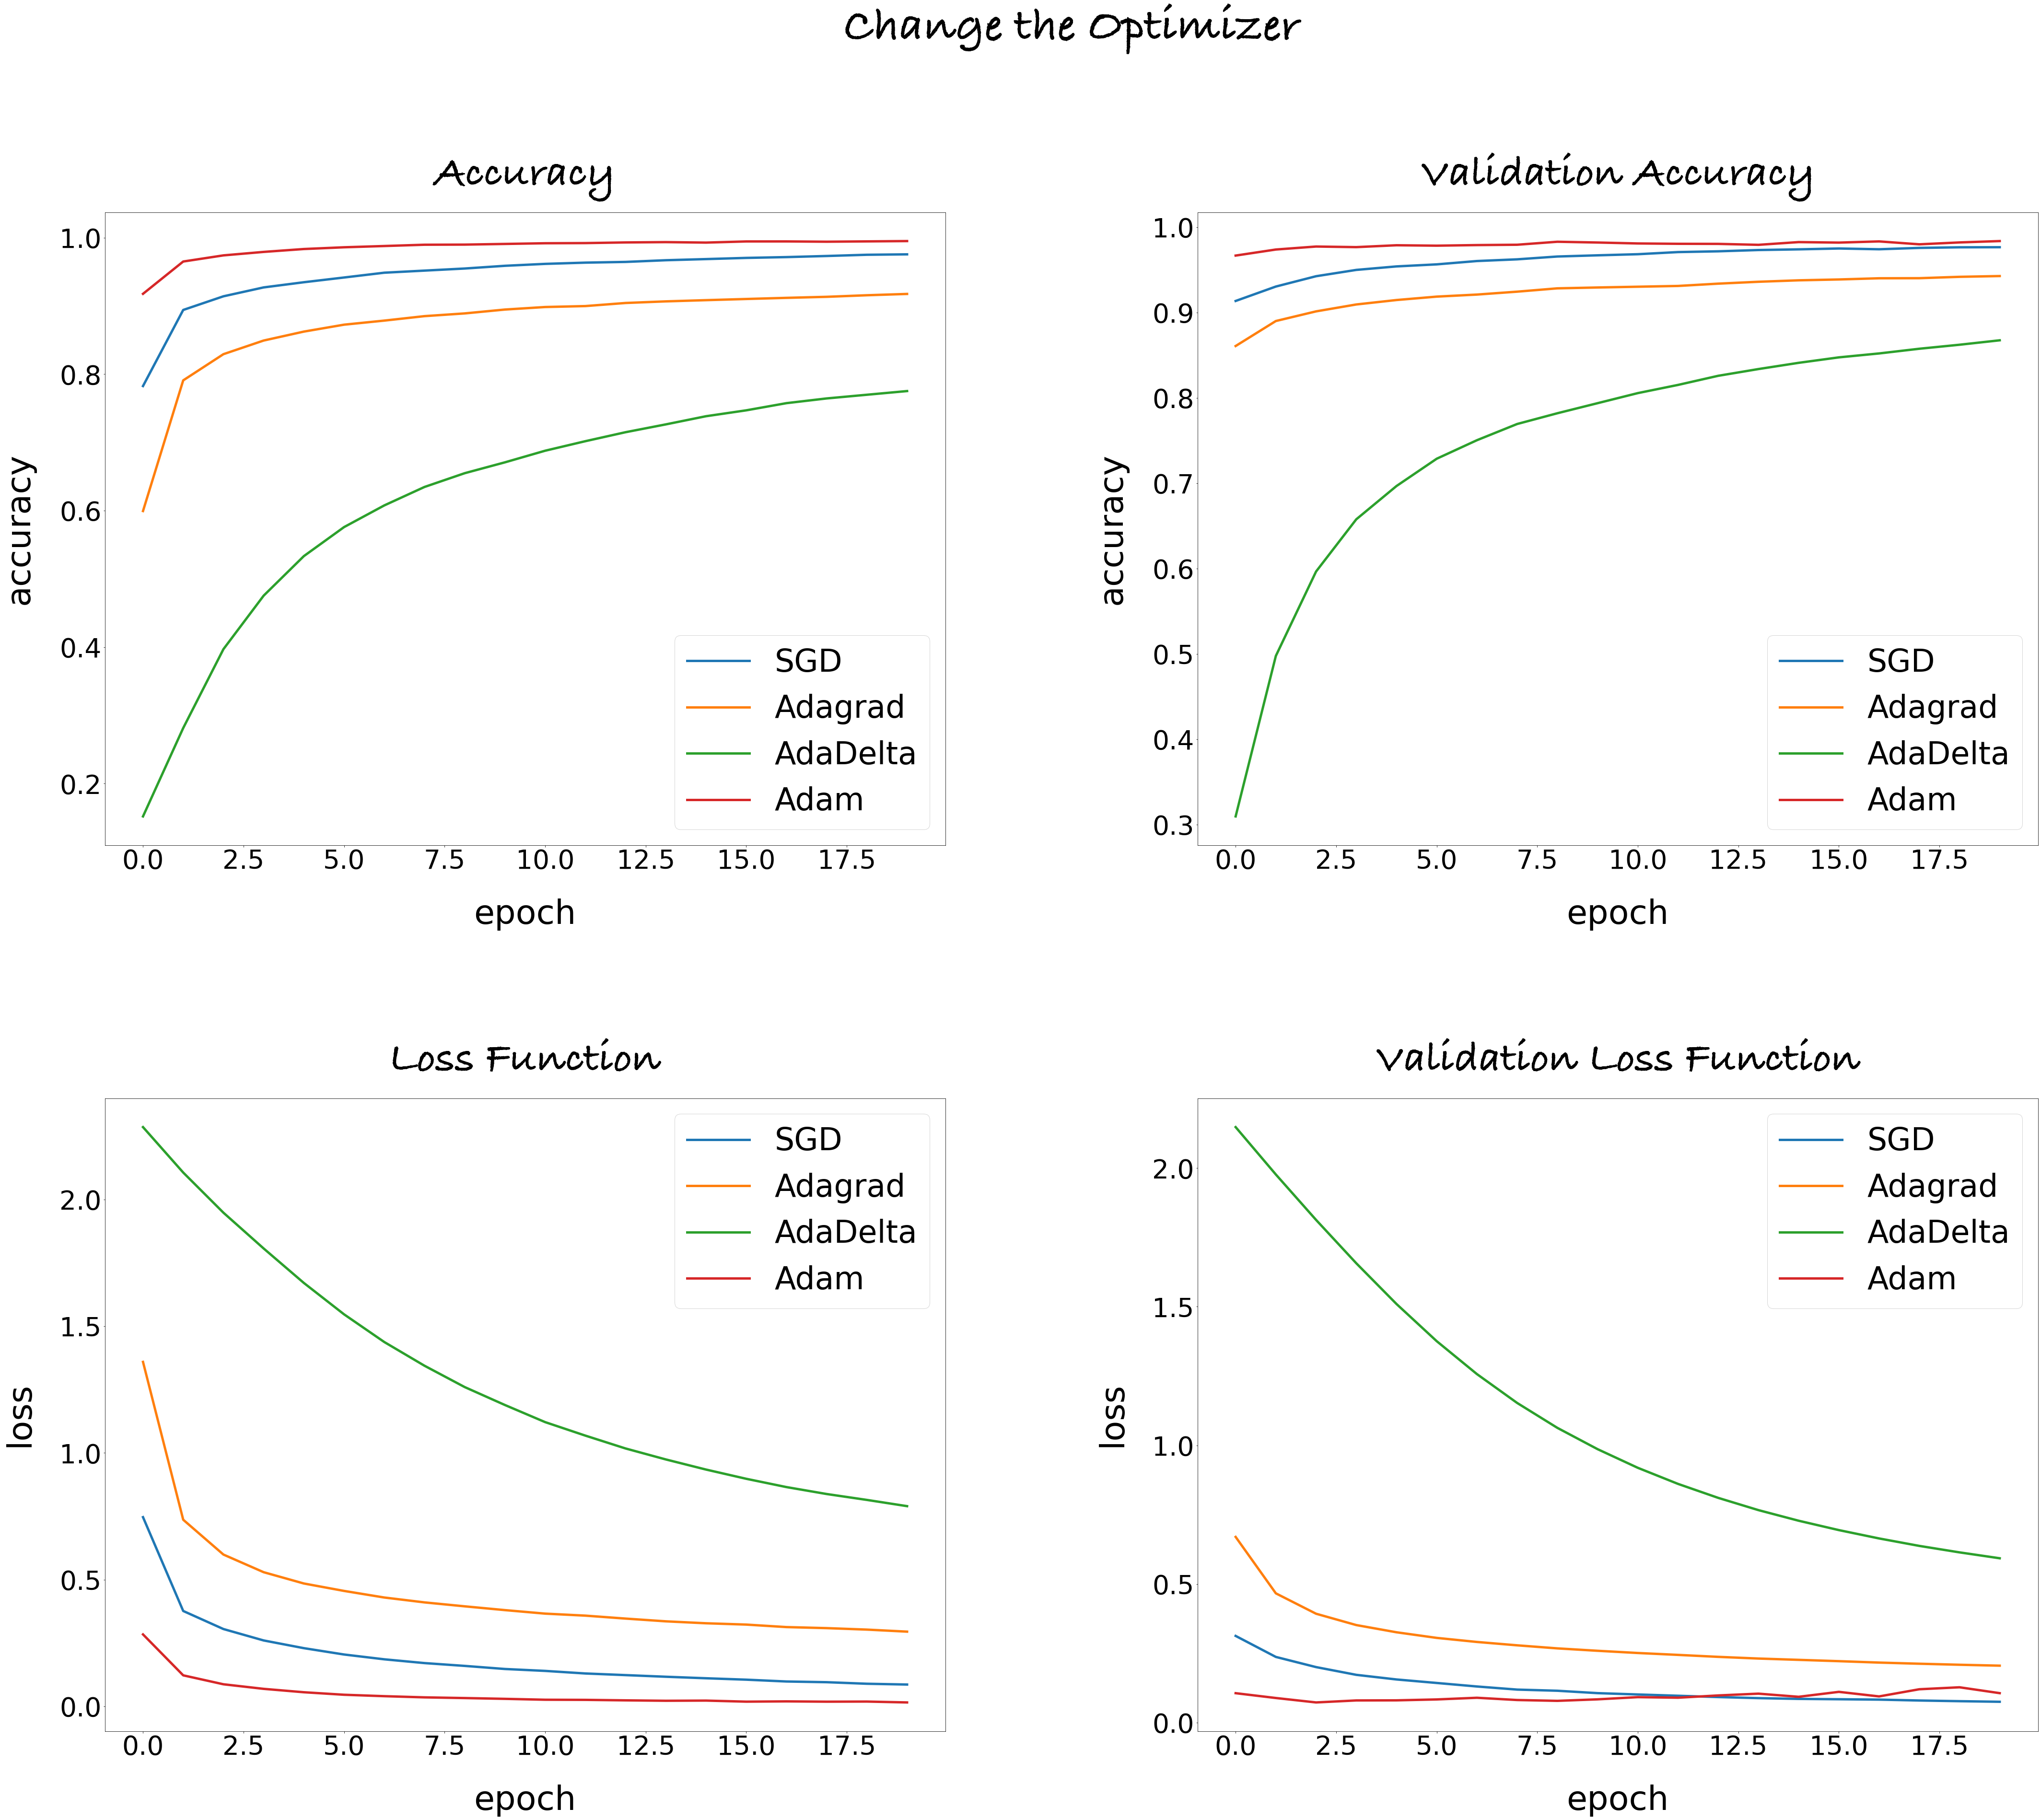

In [8]:
plt.figure(figsize=[70, 55])  #deafult (6.4,4.8)
plt.suptitle('Change the Optimizer', y=1.01, fontname = 'Bradley Hand', fontsize=100)

plt.subplot(2, 2, 1)
plt.title('Accuracy', y=1.04, fontname = 'Bradley Hand', fontsize=90)
plt.xlabel('epoch', fontsize=70, labelpad=50)
plt.ylabel('accuracy', fontsize=70, labelpad=50)
plt.xticks(fontsize=55)
plt.yticks(fontsize=55)
for k in range(len(opt)):
    plt.plot(history[k].history['accuracy'], lw=5.0, label=opt_name[k])
plt.legend(fontsize=65, loc='best')

plt.subplot(2, 2, 2)
plt.title('Validation Accuracy', y=1.04, fontname = 'Bradley Hand', fontsize=90)
plt.xlabel('epoch', fontsize=70, labelpad=50)
plt.ylabel('accuracy', fontsize=70, labelpad=50)
plt.xticks(fontsize=55)
plt.yticks(fontsize=55)
for k in range(len(opt)):
    plt.plot(history[k].history['val_accuracy'], lw=5.0, label=opt_name[k])
plt.legend(fontsize=65, loc='best')

plt.subplot(2, 2, 3)
plt.title('Loss Function', y=1.04, fontname = 'Bradley Hand', fontsize=90)
plt.xlabel('epoch', fontsize=70, labelpad=50)
plt.ylabel('loss', fontsize=70, labelpad=50)
plt.xticks(fontsize=55)
plt.yticks(fontsize=55)
for k in range(len(opt)):
    plt.plot(history[k].history['loss'], lw=5.0, label=opt_name[k])
plt.legend(fontsize=65, loc='best')

plt.subplot(2, 2, 4)
plt.title('Validation Loss Function', y=1.04, fontname = 'Bradley Hand', fontsize=90)
plt.xlabel('epoch', fontsize=70, labelpad=50)
plt.ylabel('loss', fontsize=70, labelpad=50)
plt.xticks(fontsize=55)
plt.yticks(fontsize=55)
for k in range(len(opt)):
    plt.plot(history[k].history['val_loss'], lw=5.0, label=opt_name[k])
plt.legend(fontsize=65, loc='best')

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.4)
plt.show()

In [9]:
#evaluate the models
scores = []
for m in dnn_models:
    scores.append(m.evaluate(x_test, y_test, verbose=0))

#print performance
for j in range(len(scores)):
    print('Score by using '+opt_name[j])
    print('Test loss:', scores[j][0])
    print('Test accuracy:', scores[j][1])
    print('\n')

Score by using SGD
Test loss: 0.07489398517077789
Test accuracy: 0.9766


Score by using Adagrad
Test loss: 0.20514140035063028
Test accuracy: 0.9428


Score by using AdaDelta
Test loss: 0.5925435998439789
Test accuracy: 0.8675


Score by using Adam
Test loss: 0.10599589026980984
Test accuracy: 0.9838




The best model is obviously the one in which the Adam algorithm is used as the optimizer. I note, however, that the validation loss curve may reveal in this case a situation of overfitting, increasing its value from the epoch number $ 10 $ onwards.<br>
So I do one last DNN training using just the Adam optimizer, increasing the number of epochs to 200, inserting a second layer of Dropout immediately after the first hidden layer and using the Early Stopping technique with a patience of $ 10 $ epochs.

In [10]:
x_test = x_test.reshape(x_test.shape[0], img_rows*img_cols)
best_DNN = create_DNN(input_shape=img_rows*img_cols, NN_name='DNN_Adam', hidden=2,
                      width=[400, 100], out_neurons=N_category, dropout=[0.4, 0.4],
                      activation=['relu', 'relu', 'softmax']
                      )
compile_DNN(model=best_DNN, optimizer=Adam, 
            loss=tf.keras.losses.categorical_crossentropy, metric='accuracy')
best_DNN.summary()

Model: "DNN_Adam"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 400)               314000    
_________________________________________________________________
dropout_4 (Dropout)          (None, 400)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 100)               40100     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 10)                1010      
Total params: 355,110
Trainable params: 355,110
Non-trainable params: 0
_________________________________________________________________


In [11]:
ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1)
print('Start training phase of DNN_Adam')
history_best = best_DNN.fit(x_train, y_train,                 
                            epochs=200, batch_size=100, 
                            validation_data=(x_test, y_test), 
                            shuffle=True, callbacks=[ES], verbose=0)
print('End of the training phase')

Start training phase of DNN_Adam
Epoch 00024: early stopping
End of the training phase


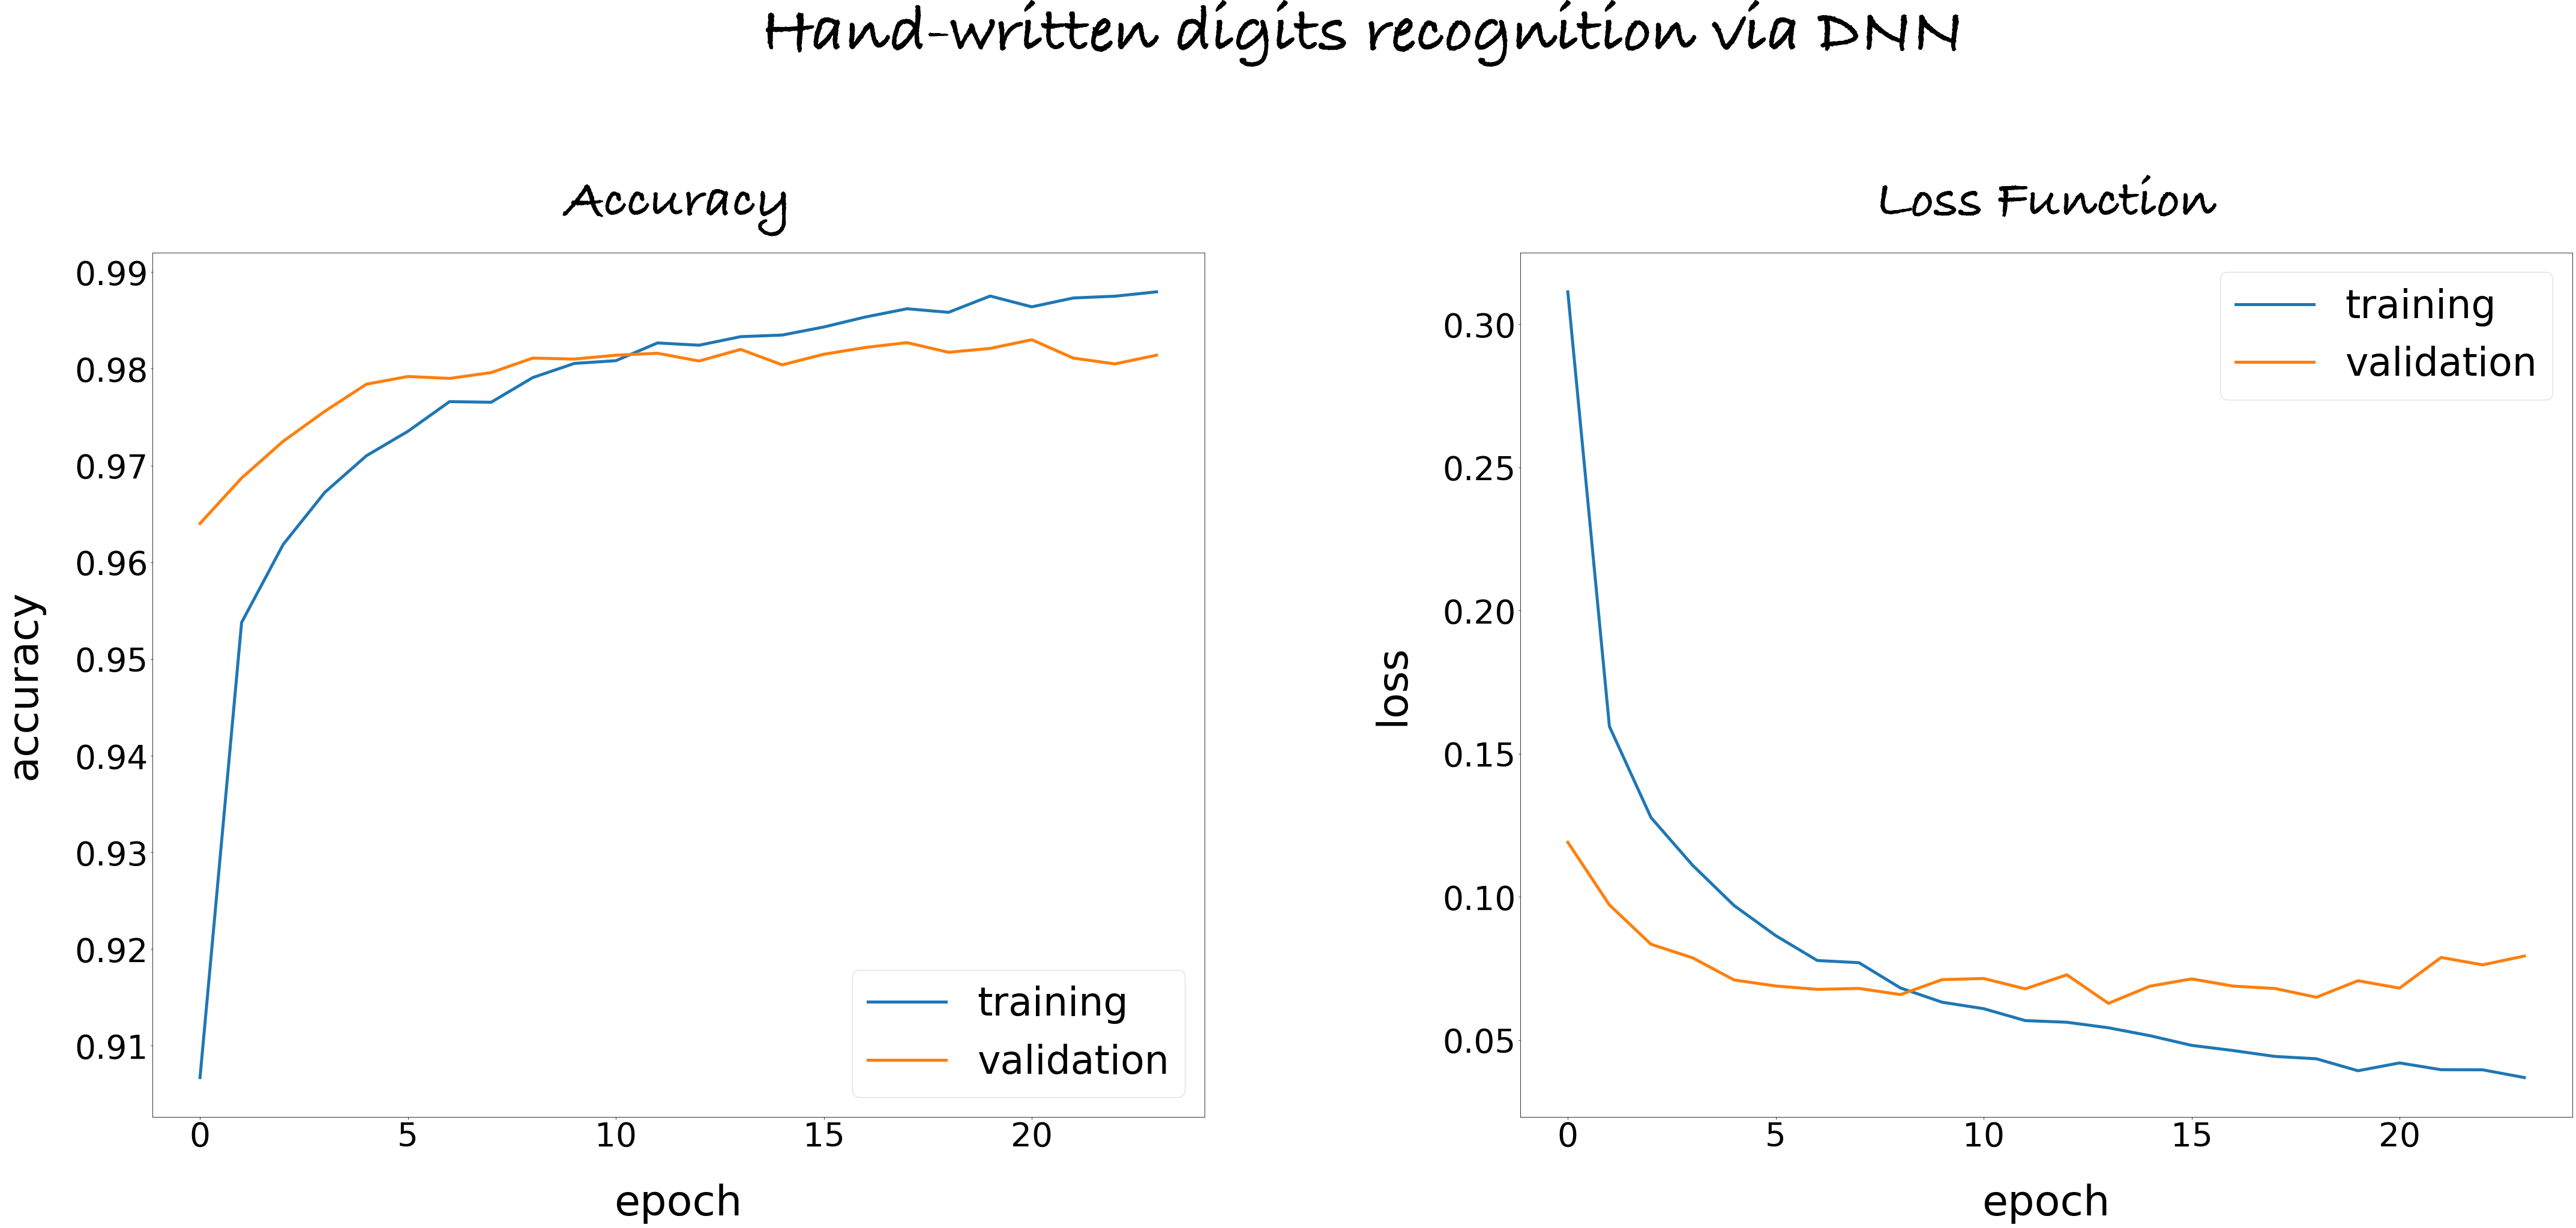

In [12]:
#Cost Function
plt.figure(figsize=[70, 25])  #deafult (6.4,4.8)
plt.suptitle('Hand-written digits recognition via DNN', y=1.13, fontname = 'Bradley Hand', fontsize=110)

plt.subplot(1, 2, 1)
plt.title('Accuracy', y=1.04, fontname = 'Bradley Hand', fontsize=90)
plt.xlabel('epoch', fontsize=70, labelpad=50)
plt.ylabel('accuracy', fontsize=70, labelpad=50)
plt.xticks(fontsize=55)
plt.yticks(fontsize=55)
plt.plot(history_best.history['accuracy'], lw=5.0, label='training')
plt.plot(history_best.history['val_accuracy'], lw=5.0, label='validation')
plt.legend(fontsize=65, loc='best')

plt.subplot(1, 2, 2)
plt.title('Loss Function', y=1.04, fontname = 'Bradley Hand', fontsize=90)
plt.xlabel('epoch', fontsize=70, labelpad=50)
plt.ylabel('loss', fontsize=70, labelpad=50)
plt.xticks(fontsize=55)
plt.yticks(fontsize=55)
plt.plot(history_best.history['loss'], lw=5.0, label='training')
plt.plot(history_best.history['val_loss'], lw=5.0, label='validation')
plt.legend(fontsize=65, loc='best')

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.4)
plt.show()


Test loss: 0.07932181510733248
Test accuracy: 0.9814




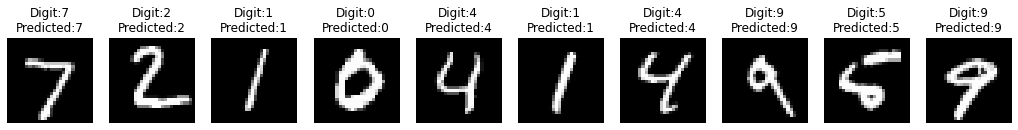

In [13]:
#evaluate the models
x_test = x_test.reshape(x_test.shape[0], img_rows*img_cols)
score = best_DNN.evaluate(x_test, y_test, verbose=0)

#print performance
print('\nTest loss:', score[0])
print('Test accuracy:', score[1])
print('\n')

#prediction
best_prediction = best_DNN.predict(x_test)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)

#plot
plt.figure(figsize=(18, 18)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(x_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit:{}\nPredicted:{}".format(np.argmax(y_test[i]), np.argmax(best_prediction[i])))    
    plt.axis('off') 
plt.show()

As you can see from the pictures above the simple Deep Neural Network I built is able to recognize the hand-written digits correctly (even managing to predict the correct number present in the penultimate figure!), obtaining a good value both for the cost function and for the accuracy during the training phase.

## <font color='blue'>Exercise 12.2</font>

In this second exercise we want to address the same classification problem of previous exercise, but using a **Convolutional Neural Network (CNN)**.
To do this I must first return the dataset in its original matrix form.

Datasets created successfully
A hand-written digits of the MNIST Dataset with categorical label [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


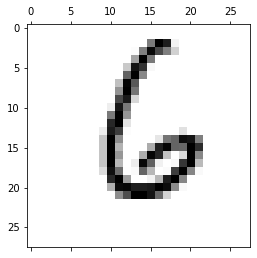

In [14]:
# #Creation of the Datasets
#Convolutional Neural Network
#MNIST Hand-written Digits
############################

'''

    (For more details see Exercise Sheet)
    Input Data --> (60000, 784) --> (60000, 28, 28) 
    Output Data --> (60000) --> (60000, 10)

'''

#reshape the dataset, depending on Keras backend
#Now the MNIST dataset is indicated with capital letters
if tf.keras.backend.image_data_format() == 'channels_first':
    X_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    X_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    X_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
Y_train = y_train
Y_test = y_test

print('Datasets created successfully')
print('A hand-written digits of the MNIST Dataset with categorical label', Y_train[32])
plt.matshow(X_train[32, :, :, :], cmap='binary')
plt.show()

I move on to the creation of the CNN architecture, which I initially decide to build in the following way: the first layer is a convolutional one, with $ 6 $ `filters`, which allows you to extract the first features from the image received in input; then follows a maximum pooling operation that calculates the maximum, or largest, value in each patch of each feature map. The addition of a pooling layer after the convolutional layer is a common pattern used for ordering layers within a convolutional neural network that may be repeated one or more times in a given model.
The pooling layer operates upon each feature map separately to create a new set of the same number of pooled feature maps. Pooling involves selecting a pooling operation, much like a filter to be applied to feature maps. The size of the pooling operation or filter is smaller than the size of the feature map; specifically, since the `Conv2D` layer has a `kernel_size` of $ (5, 5) $, I decide to set the `pool_size` to $ (3, 3) $. This means that the pooling layer will always reduce the size of each feature map from the previous convolutional layer by a factor of $ 3 $ (e.g. a pooling layer applied to a feature map of $ 6 \times 6 $ ($ 36 $ pixels) will result in an output pooled feature map of $ 2 \times 2 $ ($ 9 $ pixels)). However the use of pooling layers is useful as small changes in the location of the feature in the input detected by the convolutional layer will result in a pooled feature map with the feature in the same location. This capability added by pooling is called the *model’s invariance to local translation*. At this point I repeat this pair of layers a second time, using $ 16 $ `filters` and a `kernel_size` of $ (3, 3) $ for the `Conv2D` and a `pool_size` of $ (2, 2) $ for the `MaxPool2D`; to complete the model, I feed the last output tensor from the convolutional base (of shape (3, 3, 16)) into three `Dense` layers to perform classification. `Dense` layers take vectors as input (which are 1D), while the current output is a 3D tensor. So, first, I `Flatten` (or unroll) the 3D output to 1D; then I add two `Dense` layers on top, the first one formed by $ 120 $ neurons, the second by $ 100 $. To conclude, a last `Dense` layer of width equal to $ 10 $ and `softmax` activation function, which performs the real classification required. I decide this time to change the usual `ReLU` activation function for the hidden neurons, using the hyperbolic tangent `tanh`, which remains an activation function that introduces *non-linearity* in the output of each computational unit.<br>
I compile the model choosing as optimizer the `Adam` algorithm, which I saw before be the best choice, and using a different loss function: the `Categorical Crossentropy`.

In [15]:
############################
#Creation of a 
#Convolutional Neural Network
#Attempt 1
############################
def create_CNN(name):
    #Create a model instance
    model = tf.keras.Sequential(name=name)
    model.add(Input(shape=input_shape))
    
    #Hidden Structure
    model.add(Conv2D(filters=6, kernel_size=(5, 5), activation='tanh', input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(3, 3)))
    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='tanh'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    #Output layer
    model.add(Flatten())  #unroll the 3D output to 1D
    model.add(Dense(120, activation='tanh'))
    model.add(Dense(100, activation='tanh'))
    model.add(Dense(N_category, activation='softmax'))  #Categorical output layer

    #Compile the model
    model.compile(optimizer=Adam, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

    return model

In [16]:
CNN_recog_1 = create_CNN('CNN_1st')
CNN_recog_1.summary()

Model: "CNN_1st"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 6)           0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 6, 6, 16)          880       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 3, 3, 16)          0         
_________________________________________________________________
flatten (Flatten)            (None, 144)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 120)               17400     
_________________________________________________________________
dense_16 (Dense)             (None, 100)               1210

Above, it can be seen that the output of every `Conv2D` and `MaxPool2D` layer is a 3D tensor of shape (height, width, channels). The width and height dimensions *tend to shrink as you go deeper in the network*. Typically, as the width and height shrink, I can afford (computationally) to add more output channels in each `Conv2D` layer.<br>
All that remains is to train the CNN and evaluate its performance, as done before in the case of the DNN.<br>
For this first attempt I will not use the `Dropout` technique, nor that of the `Early Stopping`, but I simply train the Neural Network for $ 50 $ epochs.

In [17]:
print('Start training phase of CNN_1')
history_1 = CNN_recog_1.fit(X_train, Y_train,                 
                            epochs=50, batch_size=32, 
                            validation_data=(X_test, Y_test), 
                            shuffle=True, verbose=0)
print('End of the training phase')

Start training phase of CNN_1
End of the training phase


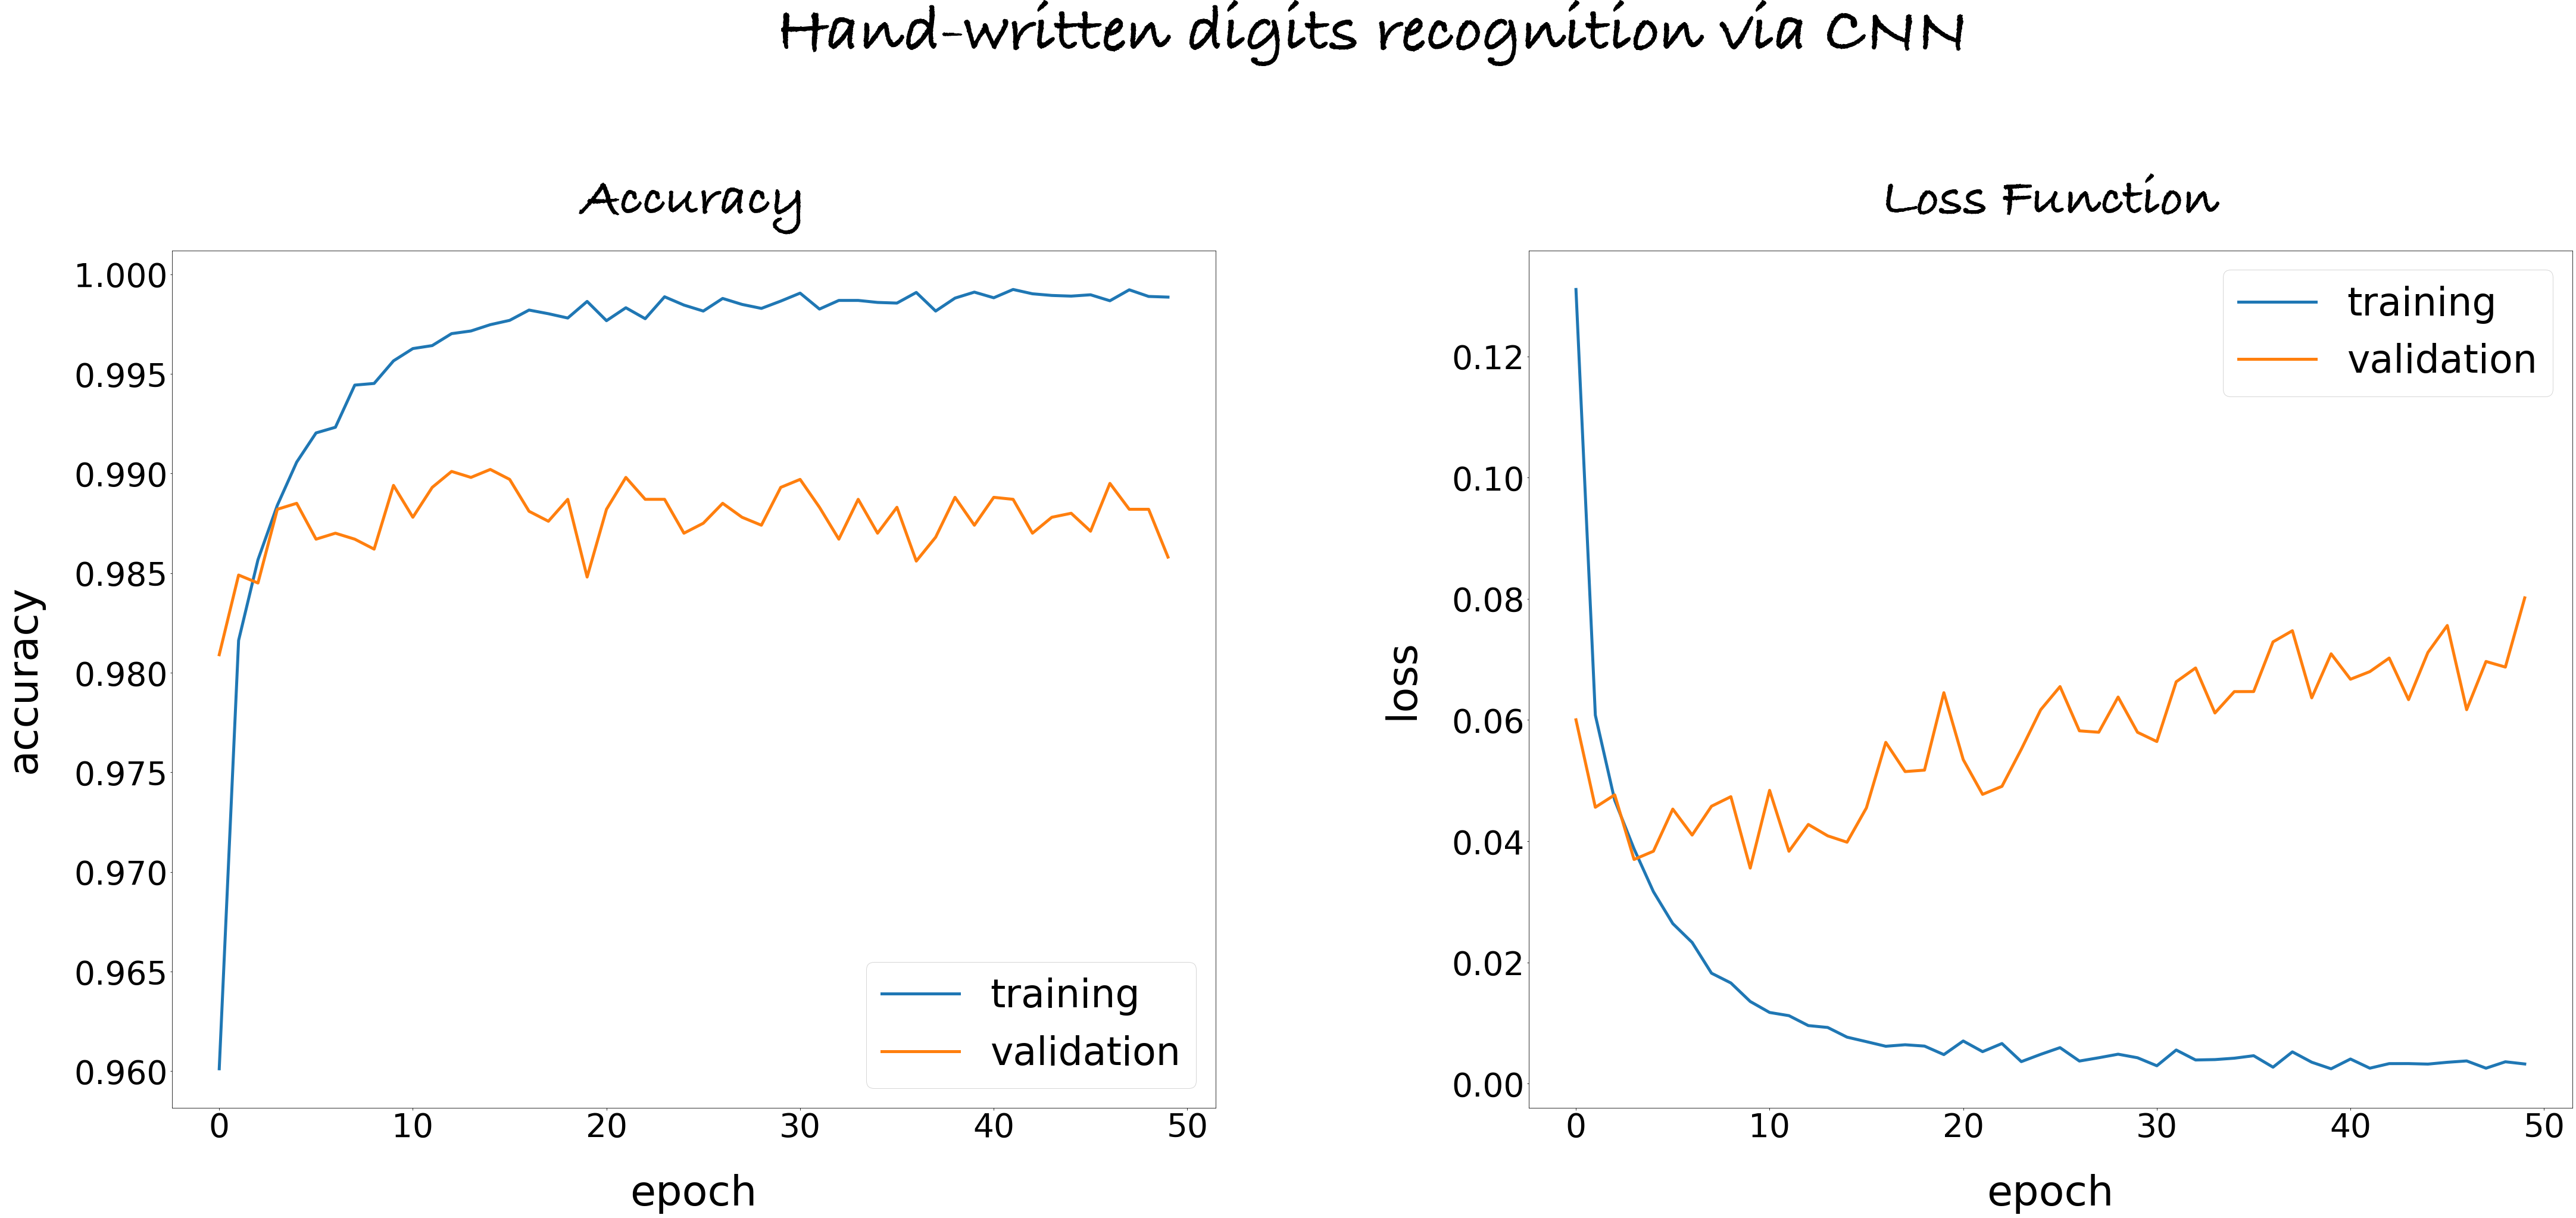

In [18]:
#Cost Function
plt.figure(figsize=[70, 25])  #deafult (6.4,4.8)
plt.suptitle('Hand-written digits recognition via CNN', y=1.13, fontname = 'Bradley Hand', fontsize=110)

plt.subplot(1, 2, 1)
plt.title('Accuracy', y=1.04, fontname = 'Bradley Hand', fontsize=90)
plt.xlabel('epoch', fontsize=70, labelpad=50)
plt.ylabel('accuracy', fontsize=70, labelpad=50)
plt.xticks(fontsize=55)
plt.yticks(fontsize=55)
plt.plot(history_1.history['accuracy'], lw=5.0, label='training')
plt.plot(history_1.history['val_accuracy'], lw=5.0, label='validation')
plt.legend(fontsize=65, loc='best')

plt.subplot(1, 2, 2)
plt.title('Loss Function', y=1.04, fontname = 'Bradley Hand', fontsize=90)
plt.xlabel('epoch', fontsize=70, labelpad=50)
plt.ylabel('loss', fontsize=70, labelpad=50)
plt.xticks(fontsize=55)
plt.yticks(fontsize=55)
plt.plot(history_1.history['loss'], lw=5.0, label='training')
plt.plot(history_1.history['val_loss'], lw=5.0, label='validation')
plt.legend(fontsize=65, loc='best')

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.4)
plt.show()


Test loss: 0.08015068332163877
Test accuracy: 0.9858




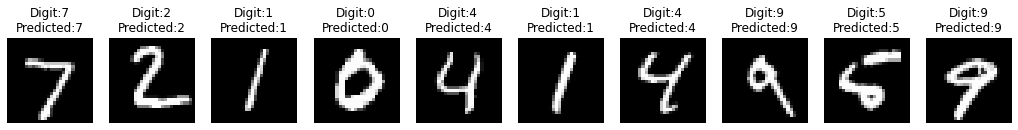

In [19]:
#evaluate the models
score_recog_1 = CNN_recog_1.evaluate(X_test, Y_test, verbose=0)

#print performance
print('\nTest loss:', score_recog_1[0])
print('Test accuracy:', score_recog_1[1])
print('\n')

#prediction
pred_recog_1 = CNN_recog_1.predict(X_test)
#X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

#plot
plt.figure(figsize=(18, 18)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(x_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit:{}\nPredicted:{}".format(np.argmax(Y_test[i]), np.argmax(pred_recog_1[i])))    
    plt.axis('off') 
plt.show()

Again, the neural network I created correctly recognizes the digits during the test. However, I am not very satisfied with the curves related to the validation dataset during the training, in particular the loss function, which does not show a clear minimization behaviour.
For this reason I decide once again to insert a `Dropout` layer after the first `Dense` layer of the top structure and to use the `Early Stopping` method. In addition, to achieve better regularization, it is useful to insert `BatchNormalization` layers after the two hidden `Conv2D` layers.
Obviously I could try to increase the number of network parameters by changing the width rather than the depth, but I prefer to keep this complexity in the architecture for the moment.

In [20]:
############################
#Creation of a 
#Convolutional Neural Network
#Attempt 2
############################
def create_CNN_improved(name):
    #Create a model instance
    model = tf.keras.Sequential(name=name)
    model.add(Input(shape=input_shape))
    
    #Hidden Structure
    model.add(Conv2D(filters=6, kernel_size=(5, 5), activation='tanh', input_shape=input_shape))
    model.add(MaxPool2D(pool_size=(3, 3)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=16, kernel_size=(3, 3), activation='tanh'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(BatchNormalization())
    
    #Output layer
    model.add(Flatten())  #unroll the 3D output to 1D
    model.add(Dense(120, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='tanh'))
    #model.add(Dropout(0.4))
    model.add(Dense(N_category, activation='softmax'))  #Categorical output layer

    #Compile the model
    model.compile(optimizer=Adam, loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

    return model

In [21]:
CNN_recog_2 = create_CNN_improved('CNN_2nd')
CNN_recog_2.summary()

Model: "CNN_2nd"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 24, 24, 6)         156       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 6)           0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8, 8, 6)           24        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 6, 6, 16)          880       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 3, 16)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 3, 16)          64        
_________________________________________________________________
flatten_1 (Flatten)          (None, 144)               0   

In [22]:
print('Start training phase of CNN_2')
ES = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=1)
history_2 = CNN_recog_2.fit(X_train, Y_train,                 
                            epochs=200, batch_size=32, 
                            validation_data=(X_test, Y_test), 
                            shuffle=True, callbacks=[ES], verbose=0)
print('End of the training phase')

Start training phase of CNN_2
Epoch 00066: early stopping
End of the training phase


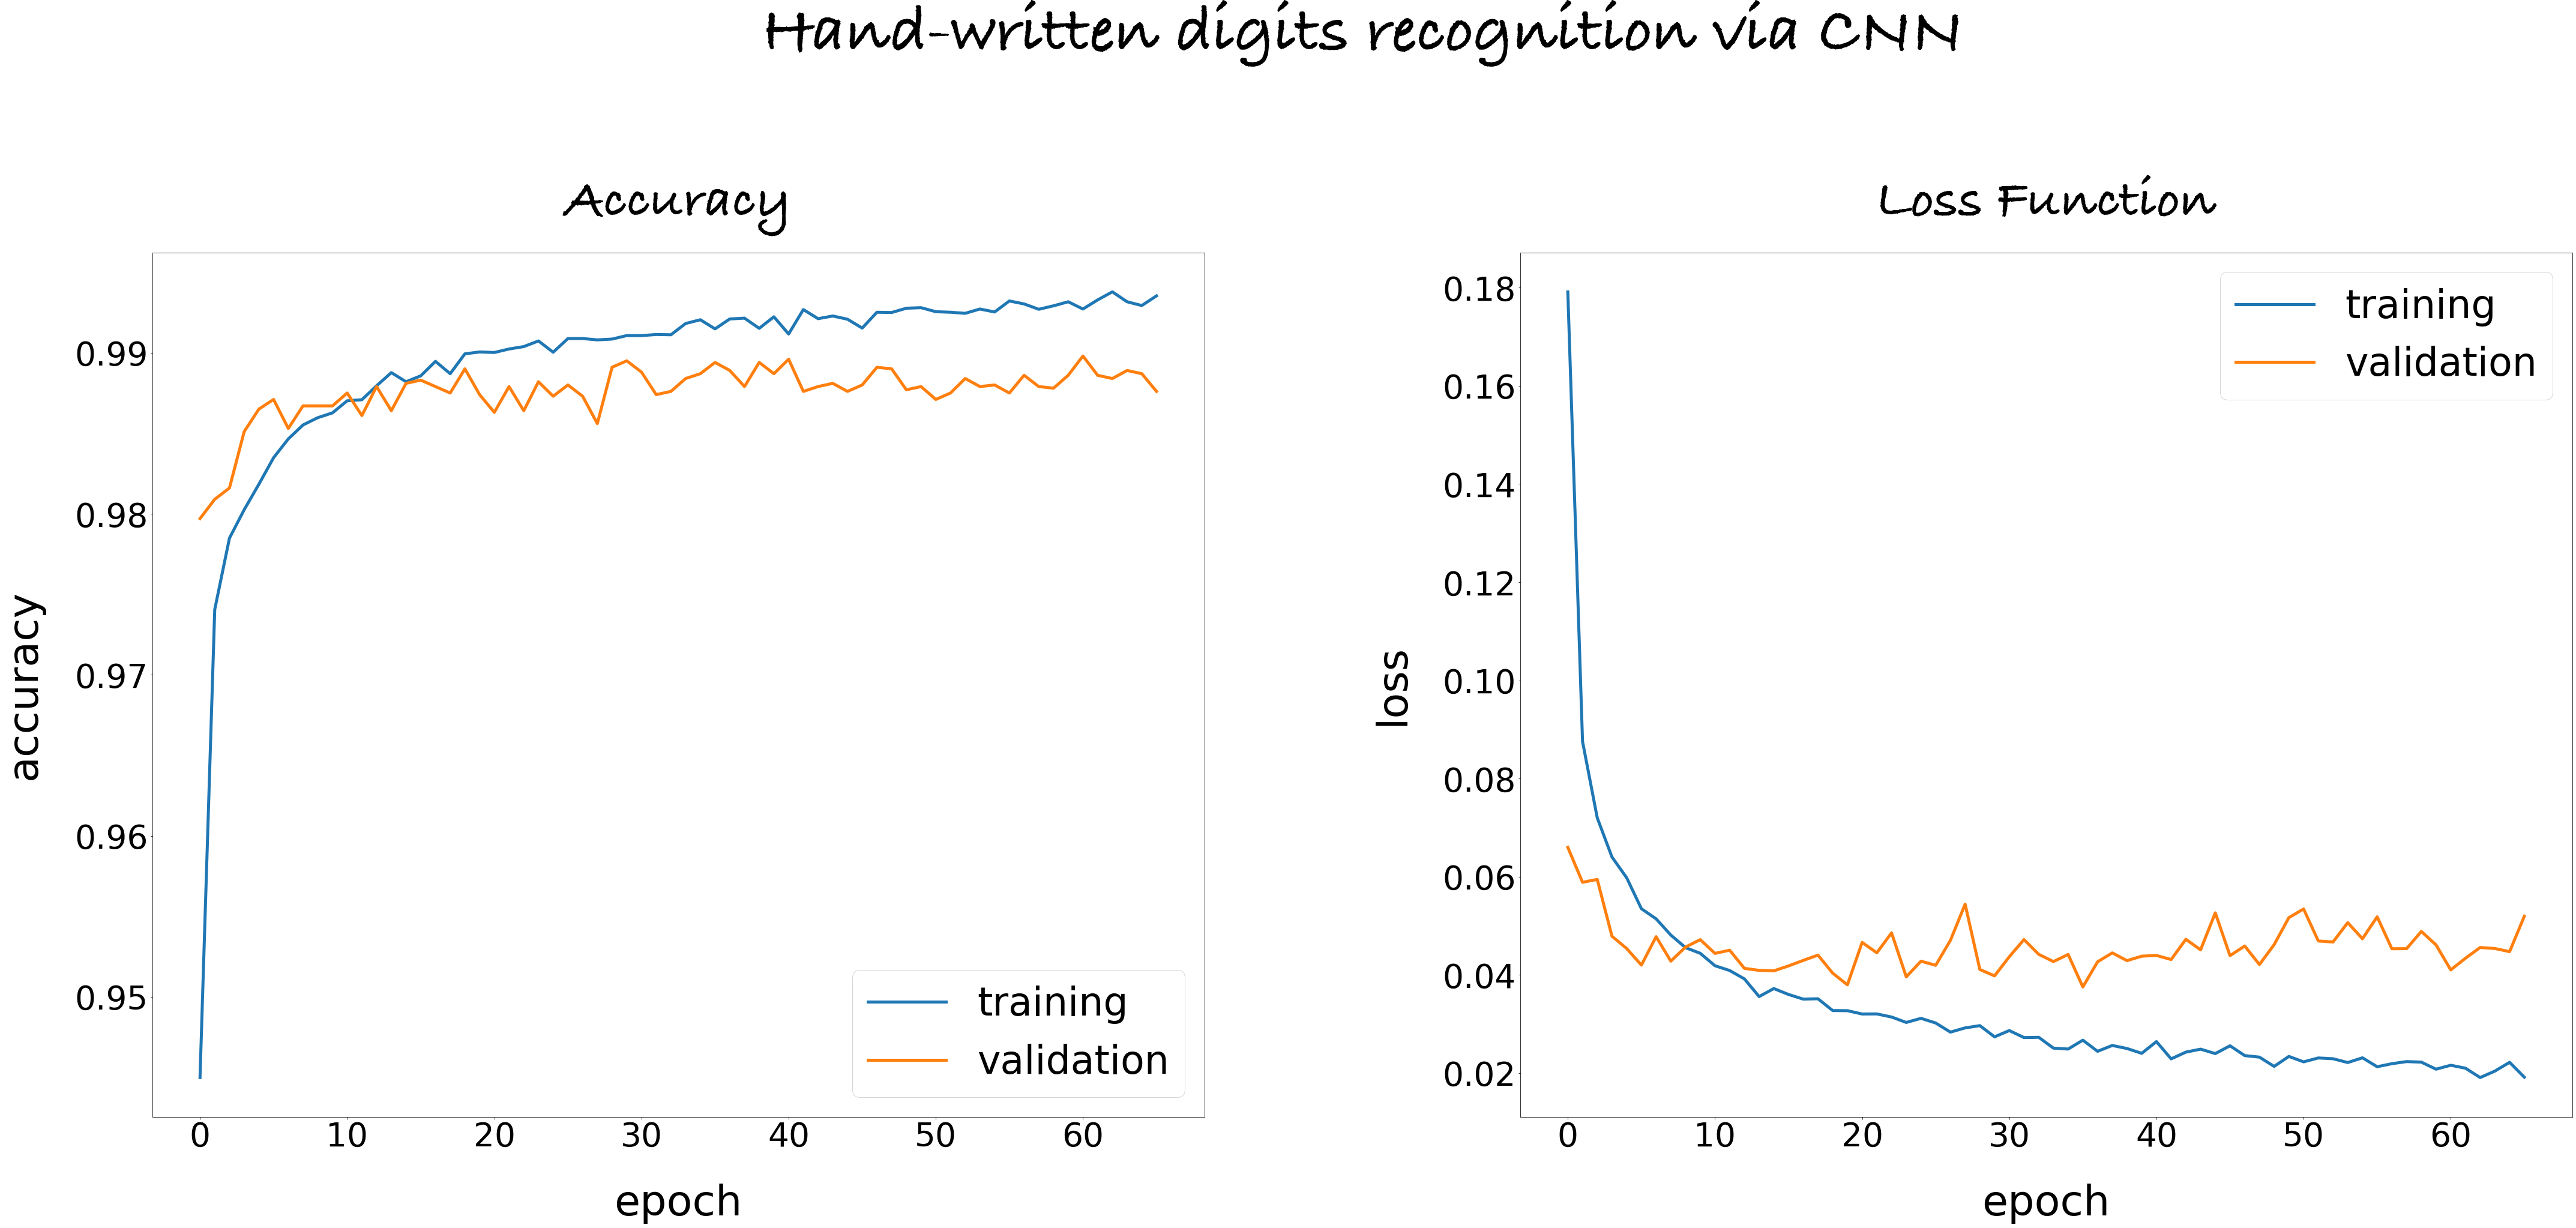

In [23]:
#Cost Function
plt.figure(figsize=[70, 25])  #deafult (6.4,4.8)
plt.suptitle('Hand-written digits recognition via CNN', y=1.13, fontname = 'Bradley Hand', fontsize=110)

plt.subplot(1, 2, 1)
plt.title('Accuracy', y=1.04, fontname = 'Bradley Hand', fontsize=90)
plt.xlabel('epoch', fontsize=70, labelpad=50)
plt.ylabel('accuracy', fontsize=70, labelpad=50)
plt.xticks(fontsize=55)
plt.yticks(fontsize=55)
plt.plot(history_2.history['accuracy'], lw=5.0, label='training')
plt.plot(history_2.history['val_accuracy'], lw=5.0, label='validation')
plt.legend(fontsize=65, loc='best')

plt.subplot(1, 2, 2)
plt.title('Loss Function', y=1.04, fontname = 'Bradley Hand', fontsize=90)
plt.xlabel('epoch', fontsize=70, labelpad=50)
plt.ylabel('loss', fontsize=70, labelpad=50)
plt.xticks(fontsize=55)
plt.yticks(fontsize=55)
plt.plot(history_2.history['loss'], lw=5.0, label='training')
plt.plot(history_2.history['val_loss'], lw=5.0, label='validation')
plt.legend(fontsize=65, loc='best')

plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.3, hspace=0.4)
plt.show()


Test loss: 0.051935125757960485
Test accuracy: 0.9876




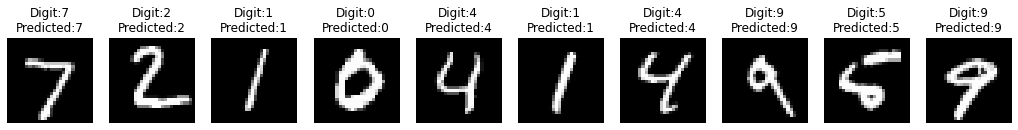

In [24]:
#evaluate the models
score_recog_2 = CNN_recog_2.evaluate(X_test, Y_test, verbose=0)

#print performance
print('\nTest loss:', score_recog_2[0])
print('Test accuracy:', score_recog_2[1])
print('\n')

#prediction
pred_recog_2 = CNN_recog_2.predict(X_test)
#X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)

#plot
plt.figure(figsize=(18, 18)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(x_test[i, :, :, 0], cmap='gray')    
    plt.title("Digit:{}\nPredicted:{}".format(np.argmax(Y_test[i]), np.argmax(pred_recog_2[i])))    
    plt.axis('off') 
plt.show()

The introduction of the layers described above improves the curves related to the loss function and accuracy, and continues to lead to the correct recognition of the figures shown above.

## <font color='blue'>Exercise 12.3</font>

In this last exercise I create the $ 10 $ hand-written digits by myself using the `gimp` application, and I try to recognize them through the two best Neural Networks that I have trained in the previous two exercises (<font face='Courier'>best_DNN</font> and <font face='Courier'>CNN_recog_2</font>).
The results obtained are as follows.

In [25]:
#Load the hand-written digits
#by myself
digit_filename = ["./0.png", "./1.png", "./2.png", "./3.png", "./4.png",
                  "./5.png", "./6.png", "./7.png", "./8.png", "./9.png"]
digit_in = []
for ndig in range(len(digit_filename)):
    digit_in.append(Image.open(digit_filename[ndig]).convert('L'))

#create an array of digits
ydim, xdim = digit_in[0].size
pix = []
for ndig in range(len(digit_filename)):
    pix.append(digit_in[ndig].load());
data = np.zeros((len(digit_filename),xdim, ydim))
for k in range(len(digit_filename)):
    for j in range(ydim):
        for i in range(xdim):
            data[k][i,j]=pix[k][j,i]
for k in range(len(digit_filename)):
    data[k] /= 255

#plt.figure(figsize=(5,5))
#plt.imshow(data[0], cmap='gray')
#plt.show()

In [26]:
#Manipulation for prediction
#DNN case
my_digits_DNN = data.reshape(data.shape[0], xdim*ydim)

#CNN case
if tf.keras.backend.image_data_format() == 'channels_first':
    my_digits_CNN = data.reshape(data.shape[0], 1, xdim, ydim)
else:
    my_digits_CNN = data.reshape(data.shape[0], xdim, ydim, 1)

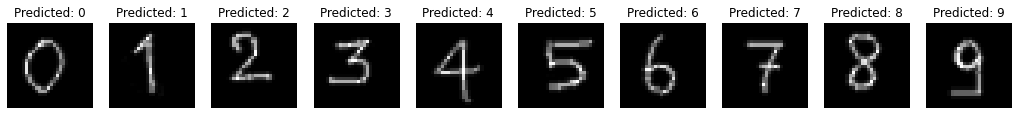

In [27]:
###########################
#Digits Recognition
#Deep Neural Network
###########################
#prediction
prediction_DNN = best_DNN.predict(my_digits_DNN)
my_digits_DNN = my_digits_DNN.reshape(my_digits_DNN.shape[0], xdim, ydim, 1)

#plot
plt.figure(figsize=(18, 18)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(my_digits_DNN[i, :, :, 0], cmap='gray')
    plt.title("Predicted: {}".format(np.argmax(prediction_DNN[i]))) 
    plt.axis('off') 
plt.show()

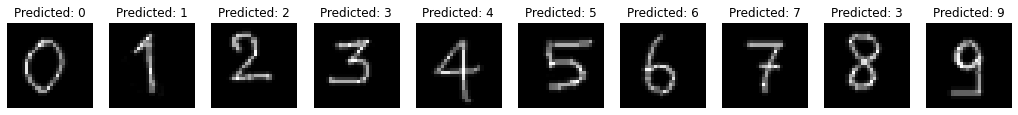

In [28]:
###########################
#Digits Recognition
#Convolutional Neural Network
###########################
#prediction
prediction_CNN = CNN_recog_2.predict(my_digits_CNN)

#plot
plt.figure(figsize=(18, 18)) 
for i in range(10):    
    ax = plt.subplot(2, 10, i + 1)    
    plt.imshow(my_digits_CNN[i, :, :, 0], cmap='gray')
    plt.title("Predicted: {}".format(np.argmax(prediction_CNN[i]))) 
    plt.axis('off') 
plt.show()

I am quite satisfied with the predictions made by my two NNs: not all digits are recognized, but most are; moreover, in the images that I created the digits appear much lighter and blurred than those of the MNIST dataset, and this confirms even more the goodness of what we found. Obviously I could have built deeper and more complex networks, but by increasing the number of parameters the computational cost (and therefore the time needed) increases exponentially.<br>
However you get excellent results despite being the architecture of the NNs very simple!